In [1]:
import pandas as pd
from pyexpat import features
from sqlalchemy.dialects.postgresql import plainto_tsquery

from scripts.evaluate_model import ModelEvaluator
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from scripts.train_model import optuna_xgb
import joblib


data = pd.read_csv('../data/processed/dataset_reduced.csv')

data = data.drop(columns=['Z', 'Period'])
data_encoded = pd.get_dummies(data, columns=['Cation', 'Anion'])

# 划分训练集和测试集
data_encoded['target_class'] = pd.qcut(data_encoded['Cs'], q=10, labels=False)
X = data_encoded.drop(['Cs', 'target_class'], axis=1)
y = data_encoded['Cs']
stratify_column = data_encoded['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)
# 加载最佳模型
best_model = joblib.load("../models/best_xgb_r.pkl")

# 重新预测
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

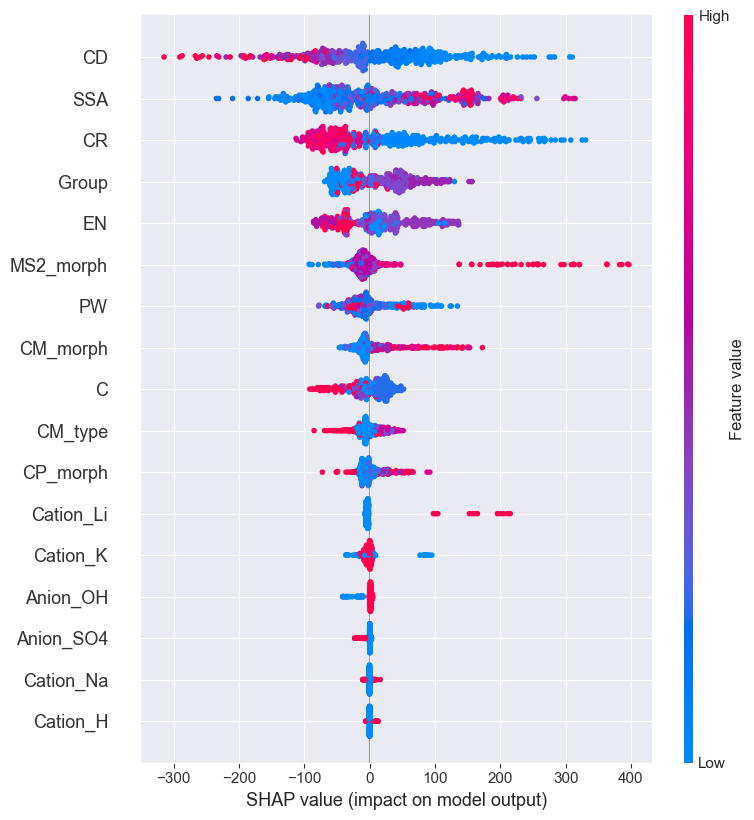

In [2]:
from matplotlib import pyplot as plt
import shap
X_train = X_train.astype({col: 'float64' for col in X_train.select_dtypes(include=['bool']).columns})

# 训练 SHAP 解释器
explainer = shap.Explainer(best_model, X_train)

# 计算 SHAP 值
shap_values = explainer(X_train)

shap.summary_plot(shap_values)

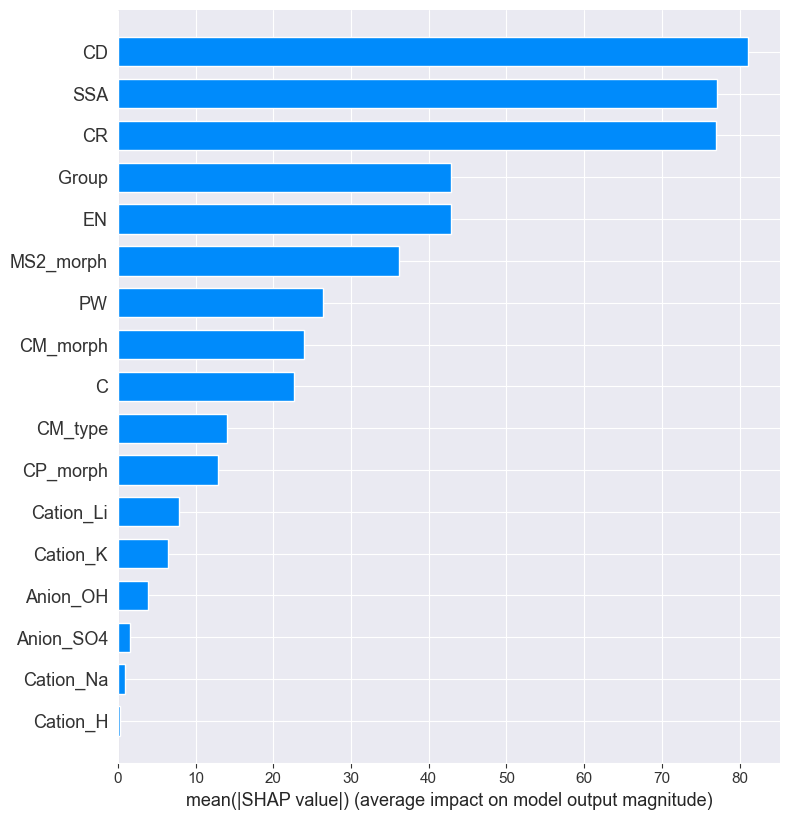

In [3]:
shap.summary_plot(shap_values, plot_type='bar')

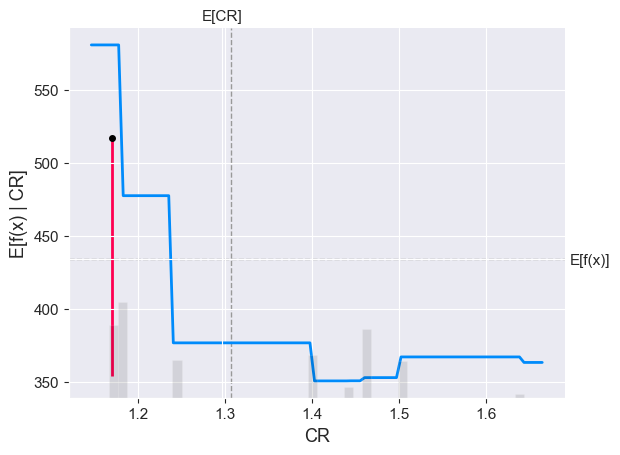

In [8]:
# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "CR",
    best_model.predict,
    X_train,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

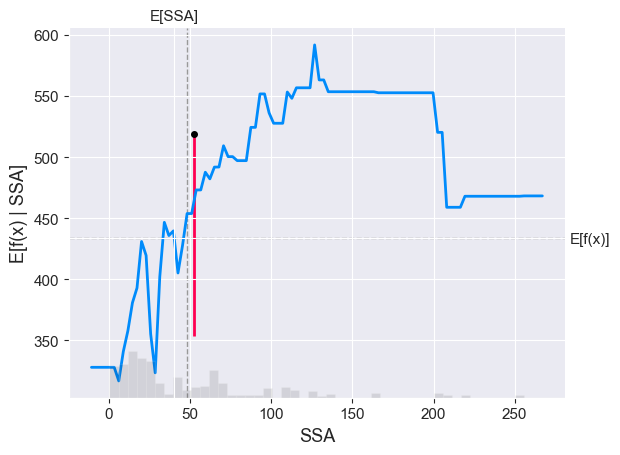

In [9]:
# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "SSA",
    best_model.predict,
    X_train,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)